In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim 
GeoLocator = Nominatim(user_agent='My-IBMNotebook')# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [13]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [14]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [15]:
df = pd.read_html(table_str)[0]
df.head()

Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [16]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [17]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [18]:
df = df_dropna

In [19]:
df.head()

PostalCode           Borough                                 Neighborhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [20]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                       Neighborhood
0  Central Toronto        M4N                      Lawrence Park
1  Central Toronto        M4P                   Davisville North
2  Central Toronto        M4R  North Toronto West, Lawrence Park
3  Central Toronto        M4S                         Davisville
4  Central Toronto        M4T        Moore Park, Summerhill East

In [21]:
# Check if we still have any Neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [Borough, PostalCode, Neighborhood]
Index: []

In [22]:
df = df_grouped

In [23]:
df.shape

(103, 3)

In [24]:
df = df[['PostalCode', 'Borough', 'Neighborhood']]

In [25]:
df.head()

PostalCode          Borough                       Neighborhood
0        M4N  Central Toronto                      Lawrence Park
1        M4P  Central Toronto                   Davisville North
2        M4R  Central Toronto  North Toronto West, Lawrence Park
3        M4S  Central Toronto                         Davisville
4        M4T  Central Toronto        Moore Park, Summerhill East

In [26]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [27]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode          Borough                       Neighborhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [28]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

## Now we will find all neighborhoods that have the Toronto in it

In [29]:
df_toronto = df
df_toronto.head()

PostalCode          Borough                       Neighborhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [30]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [31]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [32]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [84]:

map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [64]:
CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ' # your Foursquare ID
CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM' # your Foursquare Secret
VERSION = '20180604'

print('Credentials Stored')

Credentials Stored


## Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [37]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lawrence Park              43.728020              -79.388790   
1     Lawrence Park              43.728020              -79.388790   
2     Lawrence Park              43.728020              -79.388790   
3  Davisville North              43.712751              -79.390197   
4  Davisville North              43.712751              -79.390197   

                            Venue  Venue Latitude  Venue Longitude  \
0            Lawrence Park Ravine       43.726963       -79.394382   
1              Zodiac Swim School       43.728532       -79.382860   
2  TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
3                   Sherwood Park       43.716551       -79.387776   
4     Homeway Restaurant & Brunch       43.712641       -79.391557   

   Venue Category  
0            Park  
1     Swim School  
2        Bus Line  
3            Park  
4  Breakfast Spot

In [38]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                 10   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      23   
Berczy Park                                                            58   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     16   
CN Tower, King and Spadina, Railway Lands, Harb...                     16   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  12   
Cedarbrae                                                               8   
Central Bay Street                                                     64   
Christie                                                               17   
Church and Wellesley                                                   80   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             34   
Davisville North                                                        7   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        5   
Don Mills                                                              26   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview                                                              16   
Dufferin, Dovercourt Village                                           14   
East Toronto, Broadview North (Old East York)                           4   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      6   
Fairview, Henry Farm, Oriole                                           64   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                         7   
Guildwood, Morningside, West Hill                                       7   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          23   
Hillcrest Village                                                       4   
Humber Summit                                                           1   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         22   
Kennedy Park, Ionview, East Birchmount Park                             6   
Kensington Market, Chinatown, Grange Park                              60   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       11   
Lawrence Park                                                           3   
Leaside                                                                32   
Little Portugal, Trinity                                               45   
Malvern, Rouge                                                          1   
Milliken, Agincourt North, Steeles East, L'Amor.

## How many unique venues are there?

In [39]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


In [40]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Swim School' 'Bus Line' 'Breakfast Spot' 'Food & Drink Shop'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym' 'Yoga Studio' 'Diner'
 'Coffee Shop' 'Chinese Restaurant' 'Salon / Barbershop' 'Restaurant'
 'Spa' 'Mexican Restaurant' 'Clothing Store' 'Fast Food Restaurant'
 'Sporting Goods Shop' 'Café' 'Gift Shop' 'Bagel Shop'
 'Miscellaneous Shop' 'Gym / Fitness Center' 'Dessert Shop'
 'Indian Restaurant' 'Seafood Restaurant' 'Pizza Place' 'Sushi Restaurant'
 'Italian Restaurant' 'Thai Restaurant' 'Brewery' 'Toy / Game Store'
 'Greek Restaurant' 'Gas Station' 'Farmers Market' 'Gourmet Shop'
 'Pharmacy' 'French Restaurant' 'Costume Shop' 'Deli / Bodega' 'Trail'
 'Lawyer' 'Liquor Store' 'Supermarket' 'American Restaurant' 'Pub'
 'Sports Bar' 'Fried Chicken Joint' 'Bank' 'Vietnamese Restaurant'
 'Light Rail Station' 'Skating Rink' 'Health & Beauty Service' 'Garden'
 'Jewelry Store' 'Vegetarian / Vegan Restaurant' 'Burger Joint'
 'BBQ Joint' 'History Museum

## Are there any Thai Restaurants in the venues?

In [41]:
"Thai Restaurant" in toronto_venues['Venue Category'].unique()

True

## Now we will analyze each neighborhood

In [42]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2111, 277)


Neighborhoods  Accessories Store  Afghan Restaurant  Airport  \
0     Lawrence Park                  0                  0        0   
1     Lawrence Park                  0                  0        0   
2     Lawrence Park                  0                  0        0   
3  Davisville North                  0                  0        0   
4  Davisville North                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0          0       0           0              0          0         0   
1          0       0           0              0          0         0   
2          0       0           0              0          0         0   
3          0       0           0              0          0         0   
4          0       0           0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               1        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burri

In [43]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(97, 277)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.043478   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0          0.0         0.0                  0.0   
1           0.0       0.0          0.0         0.0                  0.0   
2           0.0       0.0          0.0         0.0                  0.0   
3           0.0       0.0          0.0         0.0                  0.0   
4           0.0       0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  \
0               0.0                 0.0            0.0        0.0         0.0   
1               0.0                 0.0            0.0        0.0         0.0   
2               0.0                 0.0            0.0        0.0         0.0   
3               0.0                 0.0            0.0        0.0         0.0   
4               0.0                 0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery      Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0     0.0  0.000000  0.0             0.0               0.0   
1         0.0     0.0  0.000000  0.0             0.0               0.0   
2         0.0     0.0  0.095238  0.0             0.0               0.0   
3         0.0     0.0  0.250000  0.0             0.0               0.0   
4         0.0     0.0  0.000000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Board Shop  \
0         0.0                 0.0        0.0     0.0         0.0   
1         0.0                 0.0        0.0     0.0         0.0   
2         0.0                 0.0        0.0     0.0         0.0   
3         0.0                 0.0        0.0     0.0         0.0   
4         0.0                 0.0        0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0            0.0        0.0       0.0                   0.0             0.2   
1            0.0        0.0       0.0                   0.0             0.0   
2            0.0        0.0       0.0                   0.0             0.0   
3            0.0        0.0       0.0                   0.0             0.0   
4            0.0        0.0       0.0                   0.0             0.0   

  

In [44]:
tha = to_grouped[["Neighborhoods","Thai Restaurant"]]
tha.head() #.head() shows the first five rows only

Neighborhoods  Thai Restaurant
0                                        Agincourt         0.000000
1                           Alderwood, Long Branch         0.000000
2  Bathurst Manor, Wilson Heights, Downsview North         0.000000
3                                  Bayview Village         0.000000
4                Bedford Park, Lawrence Manor East         0.043478

In [45]:
tha = tha.rename(columns={'Neighborhoods':'Neighborhood'})

## Now we will cluster the neighborhoods

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [47]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = tha.drop(['Neighborhood'], axis=1)

In [48]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 2, 0, 0, 0, 0], dtype=int32)

In [49]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [50]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/skl

Text(0, 0.5, 'Error')

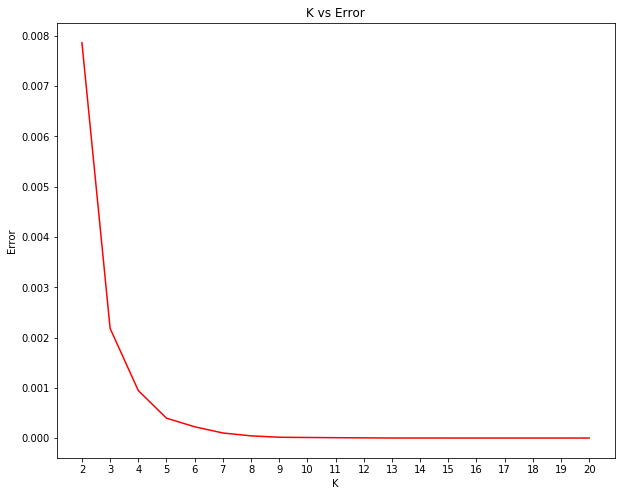

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [57]:
kclusters = 4

toronto_grouped_clustering = tha.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 2, 0, 0, 0, 0], dtype=int32)

In [58]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = tha.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [59]:
to_merged.head()

Neighborhood  Thai Restaurant  \
0                                        Agincourt         0.000000   
1                           Alderwood, Long Branch         0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North         0.000000   
3                                  Bayview Village         0.000000   
4                Bedford Park, Lawrence Manor East         0.043478   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [60]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2111, 9)


Neighborhood  Thai Restaurant  Cluster Labels  Neighborhood Latitude  \
0    Agincourt              0.0               0                43.7942   
0    Agincourt              0.0               0                43.7942   
0    Agincourt              0.0               0                43.7942   
0    Agincourt              0.0               0                43.7942   
0    Agincourt              0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.258584                     Lounge  
0       -79.259208  Latin American Restaurant  
0       -79.259714             Clothing Store  
0       -79.267989               Skating Rink

In [61]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2111, 9)


Neighborhood  Thai Restaurant  \
0                                           Agincourt         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
61                                          Parkwoods         0.000000   
61                                          Parkwoods         0.000000   
61                                          Parkwoods         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
60                    Parkview Hill, Woodbine Gardens         0.000000   
59                             Parkdale, Roncesvalles         0.000000   
59                             Parkdale, Roncesvalles         0.000000   
59                             Parkdale, Roncesvalles         0.000000   
59                             Parkdale, Roncesvalles         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
63                          Regent Park, Harbourfront         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
59                             Parkdale, Roncesvalles         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Government         0.000000   
62        Queen's Park, Ontario Provincial Go

In [62]:
to_merged['Venue Category'].value_counts()['Thai Restaurant']

21

We see that there are a total of 21 locations with Thai Restaurants in Toronto.

We will create a new dataframe with the Neighborhood and Thai Restaurants.

In [66]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

## How many Neighborhoods per Cluster?

In [67]:
tha["Cluster Labels"] = kmeans.labels_
tha.head()

Neighborhood  Thai Restaurant  \
0                                        Agincourt         0.000000   
1                           Alderwood, Long Branch         0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North         0.000000   
3                                  Bayview Village         0.000000   
4                Bedford Park, Lawrence Manor East         0.043478   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

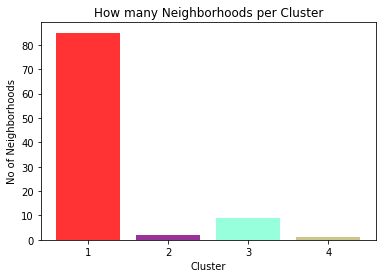

In [69]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = tha['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [71]:
# How many neighborhoods in each cluster
tha['Cluster Labels'].value_counts()

0    85
2     9
1     2
3     1
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster

### Cluster 1

In [72]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                       Neighborhood
0  Central Toronto                      Lawrence Park
1  Central Toronto                   Davisville North
2  Central Toronto  North Toronto West, Lawrence Park
3  Central Toronto                         Davisville
4  Central Toronto        Moore Park, Summerhill East

In [73]:
# Red 
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0      Central Toronto                                      Lawrence Park   
1      Central Toronto                                      Lawrence Park   
2      Central Toronto                                      Lawrence Park   
3      Central Toronto                                   Davisville North   
4      Central Toronto                                   Davisville North   
5      Central Toronto                                   Davisville North   
6      Central Toronto                                   Davisville North   
7      Central Toronto                                   Davisville North   
8      Central Toronto                                   Davisville North   
9      Central Toronto                                   Davisville North   
10     Central Toronto                  North Toronto West, Lawrence Park   
11     Central Toronto                  North Toronto West, Lawrence Park   
12     Central Toronto                  North Toronto West, Lawrence Park   
13     Central Toronto                  North Toronto West, Lawrence Park   
14     Central Toronto                  North Toronto West, Lawrence Park   
15     Central Toronto                  North Toronto West, Lawrence Park   
16     Central Toronto                  North Toronto West, Lawrence Park   
17     Central Toronto                  North Toronto West, Lawrence Park   
18     Central Toronto                  North Toronto West, Lawrence Park   
19     Central Toronto                  North Toronto West, Lawrence Park   
20     Central Toronto                  North Toronto West, Lawrence Park   
21     Central Toronto                  North Toronto West, Lawrence Park   
22     Central Toronto                  North Toronto West, Lawrence Park   
23     Central Toronto                  North Toronto West, Lawrence Park   
24     Central Toronto                  North Toronto West, Lawrence Park   
25     Central Toronto                  North Toronto West, Lawrence Park   
26     Central Toronto                  North Toronto West, Lawrence Park   
27     Central Toronto                  North Toronto West, Lawrence Park   
28     Central Toronto                  North Toronto West, Lawrence Park   
29     Central Toronto                        Moore Park, Summerhill East   
30     Central Toronto                        Moore Park, Summerhill East   
31     Central Toronto                        Moore Park, Summerhill East   
32     Central Toronto                        Moore Park, Summerhill East   
33     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
34     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
35     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
36     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
37     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
38     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
39     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
40     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
41     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
42     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
43     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
44     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
45     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
46     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
47     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
48     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
49     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
50     Central Toronto                                           Roselawn   
51     Cent

### Cluster 2

In [74]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')

In [75]:
df_cluster2.sort_values(["Thai Restaurant"], ascending=False)

Borough                             Neighborhood  Thai Restaurant  \
18  West Toronto            High Park, The Junction South         0.086957   
27  West Toronto            High Park, The Junction South         0.086957   
21  West Toronto            High Park, The Junction South         0.086957   
22  West Toronto            High Park, The Junction South         0.086957   
23  West Toronto            High Park, The Junction South         0.086957   
24  West Toronto            High Park, The Junction South         0.086957   
25  West Toronto            High Park, The Junction South         0.086957   
26  West Toronto            High Park, The Junction South         0.086957   
28  West Toronto            High Park, The Junction South         0.086957   
19  West Toronto            High Park, The Junction South         0.086957   
29  West Toronto            High Park, The Junction South         0.086957   
30  West Toronto            High Park, The Junction South         0.086957   
31  West Toronto            High Park, The Junction South         0.086957   
32  West Toronto            High Park, The Junction South         0.086957   
33  West Toronto            High Park, The Junction South         0.086957   
34  West Toronto            High Park, The Junction South         0.086957   
20  West Toronto            High Park, The Junction South         0.086957   
35  West Toronto            High Park, The Junction South         0.086957   
16  West Toronto            High Park, The Junction South         0.086957   
15  West Toronto            High Park, The Junction South         0.086957   
14  West Toronto            High Park, The Junction South         0.086957   
13  West Toronto            High Park, The Junction South         0.086957   
17  West Toronto            High Park, The Junction South         0.086957   
1    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
6    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
2    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
3    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
4    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
5    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
9    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
7    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
8    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
10   Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
11   Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
12   Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   
0    Scarborough  Clarks Corners, Tam O'Shanter, Sullivan         0.076923   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
18               1              43.661608              -79.464763   
27               1              43.661608              -79.464763   
21               1              43.661608              -79.464763   
22               1              43.661608              -79.464763   
23               1              43.661608              -79.464763   
24               1              43.661608              -79.464763   
25               1              43.661608              -79.464763   
26               1              43.661608              -79.464763   
28               1              43.661608              -79.464763   
19               1              43.661608              -79.464763   
29               1              43.661608              -79.464763   
30               1              43.661608              -79.464763   
31               1              43.661608              -79.464763   
32               1              43.661608              -79.464763   
33               1              43.661608              -79.464763   
34               1

In [76]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Thai Restaurant']

3

### Cluster 3

In [77]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                            Neighborhood  \
0     Central Toronto                              Davisville   
1     Central Toronto                              Davisville   
2     Central Toronto                              Davisville   
3     Central Toronto                              Davisville   
4     Central Toronto                              Davisville   
5     Central Toronto                              Davisville   
6     Central Toronto                              Davisville   
7     Central Toronto                              Davisville   
8     Central Toronto                              Davisville   
9     Central Toronto                              Davisville   
10    Central Toronto                              Davisville   
11    Central Toronto                              Davisville   
12    Central Toronto                              Davisville   
13    Central Toronto                              Davisville   
14    Central Toronto                              Davisville   
15    Central Toronto                              Davisville   
16    Central Toronto                              Davisville   
17    Central Toronto                              Davisville   
18    Central Toronto                              Davisville   
19    Central Toronto                              Davisville   
20    Central Toronto                              Davisville   
21    Central Toronto                              Davisville   
22    Central Toronto                              Davisville   
23    Central Toronto                              Davisville   
24    Central Toronto                              Davisville   
25    Central Toronto                              Davisville   
26    Central Toronto                              Davisville   
27    Central Toronto                              Davisville   
28    Central Toronto                              Davisville   
29    Central Toronto                              Davisville   
30    Central Toronto                              Davisville   
31    Central Toronto                              Davisville   
32    Central Toronto                              Davisville   
33    Central Toronto                              Davisville   
34   Downtown Toronto             St. James Town, Cabbagetown   
35   Downtown Toronto             St. James Town, Cabbagetown   
36   Downtown Toronto             St. James Town, Cabbagetown   
37   Downtown Toronto             St. James Town, Cabbagetown   
38   Downtown Toronto             St. James Town, Cabbagetown   
39   Downtown Toronto             St. James Town, Cabbagetown   
40   Downtown Toronto             St. James Town, Cabbagetown   
41   Downtown Toronto             St. James Town, Cabbagetown   
42   Downtown Toronto             St. James Town, Cabbagetown   
43   Downtown Toronto             St. James Town, Cabbagetown   
44   Downtown Toronto             St. James Town, Cabbagetown   
45   Downtown Toronto             St. James Town, Cabbagetown   
46   Downtown Toronto             St. James Town, Cabbagetown   
47   Downtown Toronto             St. James Town, Cabbagetown   
48   Downtown Toronto             St. James Town, Cabbagetown   
49   Downtown Toronto             St. James Town, Cabbagetown   
50   Downtown Toronto             St. James Town, Cabbagetown   
51   Downtown Toronto             St. James Town, Cabbagetown   
52   Downtown Toronto             St. James Town, Cabbagetown   
53   Downtown Toronto             St. James Town, Cabbagetown   
54   Downtown Toronto             St. James Town, Cabbagetown   
55   Downtown Toronto             St. James Town, Cabbagetown   
56   Downtown Toronto             St. James Town, Cabbagetown   
57   Downtown Toronto             St. James Town, Cabbagetown   
58   Downtown Toronto             St. James Town, Cabbagetown   
59   Downtown Toronto             St. James Town, Cabbagetown   
60   Downtown Toronto             St. James Town,

### Cluster 4 

In [78]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough Neighborhood  Thai Restaurant  Cluster Labels  \
0  Scarborough    Cedarbrae            0.125               3   
1  Scarborough    Cedarbrae            0.125               3   
2  Scarborough    Cedarbrae            0.125               3   
3  Scarborough    Cedarbrae            0.125               3   
4  Scarborough    Cedarbrae            0.125               3   
5  Scarborough    Cedarbrae            0.125               3   
6  Scarborough    Cedarbrae            0.125               3   
7  Scarborough    Cedarbrae            0.125               3   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.773136              -79.239476   
1              43.773136              -79.239476   
2              43.773136              -79.239476   
3              43.773136              -79.239476   
4              43.773136              -79.239476   
5              43.773136              -79.239476   
6              43.773136              -79.239476   
7              43.773136              -79.239476   

                          Venue  Venue Latitude  Venue Longitude  \
0     Popeyes Louisiana Kitchen       43.775930       -79.235328   
1                    B&A Bakery       43.774391       -79.243877   
2               TD Canada Trust       43.774830       -79.241251   
3  Centennial Recreation Centre       43.774593       -79.236500   
4                   Thai One On       43.774468       -79.241268   
5      Drupati's Roti & Doubles       43.775222       -79.241678   
6                  Petro-Canada       43.774106       -79.243097   
7           Federick Restaurant       43.774697       -79.241142   

         Venue Category  
0   Fried Chicken Joint  
1                Bakery  
2                  Bank  
3    Athletics & Sports  
4       Thai Restaurant  
5  Caribbean Restaurant  
6           Gas Station  
7      Hakka Restaurant

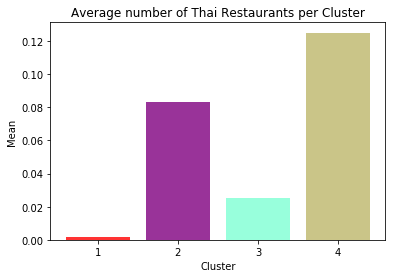

In [80]:
clusters_mean = [df_cluster1['Thai Restaurant'].mean(),df_cluster2['Thai Restaurant'].mean(),df_cluster3['Thai Restaurant'].mean(),
                 df_cluster4['Thai Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Thai Restaurants per Cluster')

plt.show()

## Observations

Most of the Thai Restaurants are in cluster 4 represented by the dark khaki clusters. The Neighborhoods located in the Scarborough area that have the highest average of Thai Restaurants are Cedarbrae. Even though there is a huge amount of Neighborhoods in cluster 1, there is little to no Thai Restaurant. We see that in the West Toronto area (cluster 2) has the second last average of Thai Restaurants. Looking at the nearby venues, the optimum place to put a new Thai Restaurant is in North York as their are many Neighborhoods in the area but little to no Thai Restaurants therefore, eliminating any competition. The second best Neighborhoods that have a great oppurtunity would be in areas such as St. James Town and Cabbagetown, etc which is in Cluster 3. Having 9 neighborhoods in the area with a little bit Thai Restaurants gives a good oppurtunity for opening up a new restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Thai restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.